### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2017 ###

# Helping Santa's Helpers - Task Scheduling #

#### Yan Nan (yan.nan@wisc.edu),  Ronak Mehta  (ronakrm@cs.wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
  1. [The Data](#1.A.-The-Data)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Scheduling Toys Task with No Resources Limited](#2.A.-Scheduling-Toys-Task-with-No-Resources-Limited)
  1. [Earlier Completion Time under Limited Resources](#2.B.-Earlier-Completion-Time-under-Limited-Resources)
  1. [Objective with Workshop Constraints](#2.C.-Objective-with-Workshop-Constraints)
  1. [Balancing Resources and Completion Time](#2.D.-Balancing-Resources-and-Completion-Time)
1. [Implementations and Functions](#3.-Implementations-and-Functions)
  1. [Implementation for 2.A](#3.A.-Implementation-for-2.A)
  1. [Implementation for 2.B](#3.B.-Implementation-for-2.B)
  1. [Implementation for 2.C](#3.C.-Implementation-for-2.C)
  1. [Implementation for 2.D](#3.D.-Implementation-for-2.D)
  1. [Schedule Plotting](#3.E.-Schedule-Plotting)
1. [Results and Discussion](#4.-Results-and-Discussion)
  1. [Parts A,B, and C](#4.A.-Parts-A,B,-and-C)
  1. [Part D: Pareto Tradeoffs](#4.B.-Part-D:-Pareto-Tradeoffs)
  1. [Solver Comparisons](#4.C.-Solver-Comparisons)
  1. [Productivity Modeling](#4.D.-Productivity-Modeling)
1. [More Discussion, Future Work, and Conclusions](#5.-More-Discussion,-Future-Work,-and-Conclusions)

## 1. Introduction ##

This problem is helping Santa to make a toy-production schedule which  meets his toy target while keeping his elves healthy and happy.

In this project we tackle the problem of highly-constrained scheduling. While we discussed assignment and scheduling models in class, those models are often too simple to model real world scheduling requirements. Particularly, there may be very intricate dependencies between tasks, or resource restrictions and complications that make applying simple methods difficult. Later we saw that dependencies could be modeled as first-order logic, and that those logic statements could be turned into linear constraints. With this new tool we were able to generalize assignment problems to more complex tasks.

Here, we make an effort to apply those concepts discussed to a more realistic scheduling problem. Santa is on a tight schedule and needs to ensure that his workshop works efficiently and that he meets his toy target for the year. His workshop is comprised of many elves, each of which can make toys throughout the workday, throughout the year.

In this job scheduling problem, we should assign (1) which elves work on which toys and (2) at what time they work. The goal is to complete all of the toys as early as possible. This particular problem setup was taken from a Kaggle competition, where we attempt to minimize the following objective:
                                            S= $t_f$ ∗log(1+ $n_e$).
                                           
where  $t_f$  is the last minute the final toy is complete, and
       $n_e$ is the number of unique elves that were needed to build the toys.

Additionally, there are specific constraints specifying toy and elf constraints. Specifically, there are three types of constraints in this model.

**For toys:**

(1) Work on toys cannot start before the order comes in but can start any time after it comes in. $T_{start}$ ≥ $T_{arrival}$

(2) Once work on a toy starts, it must continue until the toy is complete, and it must be performed by only one elf. (an elf cannot start work one day, stop, and then resume the next morning, or have a different elf resume the work)


**For working conditions:**

(1) Santa's Workshop opens for the year on January 1, 2014 at 9:00 am North Pole Time. Sanctioned elf working hours are every day, 7 days a week, from 9:00 to 19:00 (10 hours per day). Work outside of these hours are unsanctioned and penalized.

(2) Every minute worked during unsanctioned hours must be compensated with a rest period of equivalent time during sanctioned hours.

• e.g: If an elf works from 14:00-19:33, the next time he can work is the following day at 9:33. Thus 33 minutes overtime results in 33 minutes rest time.

(3 )An elf with no accrued resting period may start work at any time.

**For Elves**

There are 900 elves in Santa's Workshop, every elf is described by an id and a productivity rating.

(1) For every elf j, there is a workload for him. (PartA)

(2) Minimum and maximum values for the productivity rating are 0.25 and 4.0, respectively. All elves start the year with a productivity rating of 1.0.

(3) If the elf works during sanctioned work hours, an elf's productivity increases as
$ p = p′ ∗ (1.02)^n $

(4) If the elf works during unsanctioned work hours, an elf's productivity increases as
$ p = p′ ∗ (0.9)^n $

**Type of model**

This is very clearly a Mixed-Integer Linear Programming (MILP) problem, with a nonlinear objective. The complexity of the model largely comes from the dependencies and logical conditions imposed by the problem description, as well as some of the dynamic aspects including productivity.

### 1.A. The Data ###

An important part of this problem is the large scale of the input data. In particular, the 10 million toys are identified by their arrival time and their duration. The comma-separated value (CSV) file included with the problem statement is 280 MB. In order to test our formulations, we first crop the file to only the first 100 toys and save it ("test.csv"), and we only read the first $nToys$ number of rows from the CSV.

In [1]:
using DataFrames;
nToys = 100;
raw = readtable("test.csv", nrows = nToys);

ToyId = raw[1:nToys,:ToyId];
Duration = raw[1:nToys,:Duration];
Arrival_datetime = raw[1:nToys,:Arrival_time];

Additionally, the formatting of the arrival time needs to be configured into a more natural format. We use the convention that January 1st, 2014 is "Time 0". With this, we can measure all time as minutes since Time 0. The following converts the time format for arrival times to this convention.

In [2]:
function getGlobalArrivalTimes(Arrival_datetime, DTFormatString)
    # Format the arrival time into standard DateTime, and then use the time since the start of the year as a base
    # Also format to minutes since start of year
    # Input: Datetimes with format specified in the DTFormatString
    
    nToys = size(Arrival_datetime,1);
    Arrival_time = zeros(nToys);
    for i in 1:nToys
        Arrival_time[i] = Dates.Minute(DateTime(Arrival_datetime[i], DTFormatString)) 
        - Dates.Minute(DateTime("2014 1 1 00 00", DTFormatString));
    end
    
    return Arrival_time;
end


getGlobalArrivalTimes (generic function with 1 method)

In [3]:
DTFormatString = "y\ m\ d\ H\ M";
Arrival_time = getGlobalArrivalTimes(Arrival_datetime, DTFormatString);

## 2. Mathematical model ##

We begin with the simple model, in this model, we are given $n$ toys (tasks) and $m$ elves (resources). 
For every toy, we have variables and constants indicating (1) its arrival time $arrive_i$, (2) its start time $s_i$, (3) its finishing time $t_i$, and (4) its build time $duration_i$; (In more complicated models, the duration changes from a constant input to a dynamic variable, as the productivity of an elf influences how quickly the toy can be made.)

As we show above, the goals are 

1. complete all the toy assignments as early as possible.
2. minimize the numbers of used elves. 

In the process of modeling, we first model the problems separately, and then attempt to combine them into one formulation which minimizes some combination of elves and last toy completion time.


### 2.A. Scheduling Toys Task with No Resources Limited ##

In this nai\"ve setup, we are only interested in accurately modeling toys being built as they come in, and that these toys are built as soon as possible. Without any elf constraints, we expect that solutions to this simple **Linear Program** will complete by the greatest arrival time + duration.

#### Decision Variables: ####

2. Define $s_i$ to be the time to begin work on toy i,for toy $i=1, 2, \ldots, n$ . 
3. Define $a_i$ to be the arrival time for each toy.
4. Define $z$ to be the time to complete all toys (or the time at which the last toy is completed).

#### Constraints: ####

1. For each toy $i$, the ending time of the toy i cannot exceed $z$. That is, $\forall i, s_i + w_i \leq z$.
2. For each toy $i$, the start time of the toy i cannot preceed its arriving time. That is, $\forall i, s_i \geq a_i$.

#### Objective: ####

minimize z (the finishing time of the last toy.)

#### Standard Form ####
$$
\begin{aligned}
\text{minimize} \qquad & z \\
\text{subject to} \qquad &  \\
& \ w_i + s_i \leq z \qquad  i=1, 2, \ldots, n \\
& \ s_i \geq a_i \qquad  i=1, 2, \ldots, n \\
\end{aligned}
$$



### 2.B. Earlier Completion Time under Limited Resources ###

In this situation we extend the simple model above to one where we have a fixed number of workers and still want to finish all assignments as soon as possible. Here our model becomes significantly more complex: If we assign two assignments to the same worker, the working time of them cannot conflict. This requires significantly more variables and constraints as outlined below. **This is a MILP model.** These variables are indicators, or binary variables, and need to be modeled as such.

Let $x_{ij}$ be the binary variable to indicate whether toy $i$ is assigned to elf $j$, and $s_i$ be the variable for the starting time of toy $i$, then we can express it as following logic statement: 
$$\text{if} \sum\limits_{j=1}^m x_{ij} x_{kj} = 1 \text{, then } s_i +w_i \leq s_k \text{ or } s_k +w_k \leq s_i$$
For this logic statement, we need:


#### Decision Variables: ####

1. a binary variable $u_{ikj}$ to indicate whether toy i and toy j are scheduled on elf $j$. That is, $u_{ikj}=1$ iff $x_{ij} = x_{kj} = 1$.
2. a binary variable $v_{ik}$ to indicate whether toy $i$ completes before toy $k$. That is, if $v_{ik}=1$ then $s_i+w_i\leq s_k$.
3. a binary variable $r_{ik}$ to indicate whether toy $k$ completes before toy $i$. That is, if $r_{ik}=1$ then $s_k+w_k\leq s_i$.

#### Constraints: ####

The logical constraints enforcing no conflicts can then be written as a set of linear constraints for the pair of tasks $i,k$ are:
1. For each $j$, we have $x_{ij} \geq u_{ikj}$, $x_{kj} \geq u_{ikj}$, and $x_{ij} + x_{kj} \leq u_{ikj} +1$;
2. $s_i+w_i-s_k \leq U (1-v_{ik})$, where $U$ is an upper bound of $s_i+w_i-s_k$.
3. $s_k+w_k-s_i \leq U (1-r_{ik})$, where $U$ is an upper bound of $s_k+w_s-y_i$ (Symmetric, so same as above).
4. $\sum\limits_{j=1}^m u_{ikj} \leq v_{ik} + r_{ik}$


### 2.C. Objective with Workshop Constraints ###

The above models do not take into consideration that the workshop is only open for certain periods of the day, and that elves are penalized for working during unsanctioned (abnormal) work hours. This also introduces another set of constraints, in that toys must be completed in one work day. In a simple model, let us assume that toys cannot be built outside of normal work hours.

#### Decision Variables: ####

To account for our global time framework, we need to introduce a "day" variable. Define an _integer_ variable $d_{i}$ to indicate which day toy $i$ is built, for toy $i=1, 2, \ldots, n$ and day $1 \leq d_{i} \leq 365$. 

#### Constraints: ####

The constraints must reflect that a toy's start time should be after the opening workshop time, and that the toy is completed before the workshop closes for that day. These end up being simple linear constraints:

1. A toy must start after the opening time for that day: $\forall i, s_i \geq OpenTime_{d[i]}$
2. A toy must finish before the closing time for that day: $\forall i, s_i + Duration_i \leq CloseTime_{d[i]}$.

The open and close times, can be explicitly written in our global time framework as the following:

$$ OpenTime_{day(i)} = 9AM + 60*24*(i - 1) $$
$$ CloseTime_{day(i)} = 7PM + 60*24*(i - 1) $$

Where $9AM,7PM$ are 540 and 1140 in minutes. We define the constants $wksp\_open$ and $wksp\_clos$ to be these constants.

#### Standard Form ####
Building on our formulations above, we add the following constraints to the model:

$$
\begin{aligned}
s_i &\geq wksp\_open + 60*24*(d[i] - 1), \qquad \forall i=1, 2, \ldots, n \\
s_i + Duration_i &\leq wksp\_clos + 60*24*(d[i] - 1), \qquad \forall i=1, 2, \ldots, n \\
\end{aligned}
$$



### 2.D. Balancing Resources and Completion Time ###

In some situations, we want to decrease the number of workers we use as well as complete as early as possible. In our problem, our goal is minimize the following objective:
                                            S= $t_f$ ∗log(1+ $n_e$).
                             
                                           
where  $t_f$  is the last minute the final toy is complete.
       $n_e$ is the number of unique elves that were needed to build the toys.

                       
**This is a MINLP model.**  

In this problem, we attempted to solve the problem using the following MINLP solvers: CouenneNLSolver(),OsilCouenneSolver(),OsilBonminSolver(),BonminNLSolver(). Unfortunately, however, we were unable to resolve many dependency issues, and even for those solvers which we were able to run, they were unable to find a solution and failed.

As a proxy to this nonlinear dependent objective, we modeled this problem as a trade-off between number of elves and earliest completion time, as discussed in class. This reduces the problem again to an **MILP** problem, which we can solve.


#### Objective: ####

minimize $t_f$ + $\lambda n_e$

#### Standard Form ####
$$
\begin{aligned}
\text{minimize} \qquad & z + \lambda n_e  \\
\text{subject to} \qquad & ...
\end{aligned}
$$


## 3. Implementations and Solutions ##

The following implementations use JuMP, Gurobi, and other solvers specific to Mixed Integer Linear Programming.

### 3.A. Implementation for 2.A ###


In [4]:
using JuMP, Gurobi

function noElfModel(Duration, Arrival_time)
    # Duration: Duration of each toy.
    # Arrive_time: The arrive time of every toy.

    # return: (z) where
    # 1. z is the earliest completion time 
    
    num = length(Duration) # number of toys
    
    m = Model(solver = GurobiSolver(OutputFlag=0))
    
    @variable(m, z)                                            # the earliest completion time 
    @variable(m, s[1:num])                                     # the start time of every toy
    
    for i = 1:num
        @constraint(m, s[i] >= Arrival_time[i])                # starting doing a toy should after it arrives 
    end

    for i=1:num
        @constraint(m, s[i]+ Duration[i] <= z)
    end
                            
    @objective(m, Min, z)
                            
    status = solve(m)
    
    return (getvalue(z))
end

noElfModel (generic function with 1 method)

### 3.B. Implementation for 2.B ###

In [5]:
using JuMP, Gurobi

function minFinishTimeConflict(Duration, Arrival_time, num_elves, Upper)
    # Duration: Duration of each toy.
    # Arrive_time: The arrive time of every toy.
    # num_elf: the number of elves which will assign works.
    # Upper: a common upper bound used to ensure toys on the same elf donot overlap
    
    # return: (s,x,z) where
    # s is the starting times of each toy
    # x is which elf is working on which toy
    # z is the earliest completion time 
    
    num = length(Duration) # number of toys
    
    m = Model(solver = GurobiSolver(OutputFlag=0))
    ########################################## Variables #########################################   
    
    @variable(m, x[1:num, 1:num_elves], Bin)                        # whether toy i is scheduled on elf j
    @variable(m, z)                                               # the earliest completion time 
    @variable(m, s[1:num])                                        # the start time of every toy
    @variable(m, u[1:num, 1:num, 1:num_elves], Bin)                 # whether both toy i,k are scheduled to elf j
    @variable(m, v[1:num, 1:num], Bin)                            # whether toy i completes before toy k
    @variable(m, r[1:num, 1:num], Bin)                            # whether toy k completes before toy i
    ########################################## Constraints #########################################
    for i = 1:num
        @constraint(m, s[i] >= Arrival_time[i])                   # starting doing a toy should after it arrives 
    end
    
    for i=1:num 
        @constraint(m, sum(x[i,j]for j=1:num_elves) == 1)           # Only 1 elf should build each toy
    end
                
    for i=1:num
        @constraint(m, s[i]+ Duration[i] <= z)                    # We want to minimize the time needed for all toys
    end
     
    
    ####################################### handle the conflict constraints #########################################
    for i=1:num-1
        for k=i+1:num
            for j=1:num_elves
                
                @constraint(m, x[i,j] >= u[i,k,j])              # whether toys i,k are scheduled to the same elf j
                @constraint(m, x[k,j] >= u[i,k,j])
                @constraint(m, x[i,j] + x[k,j] <= u[i,k,j] + 1)
            end
        end
    end
    
    for i=1:num
        for k=1:num 
            
            @constraint(m, s[i]+Duration[i]-s[k] <= Upper*(1-v[i,k]))       # whether toy i completes before toy k 
            @constraint(m, s[k]+Duration[k]-s[i] <= Upper*(1-r[i,k]))       # whether toy k completes before toy i
        end
    end
    
    for i=1:num
        for k=1:num 
            @constraint(m, sum(u[i,k,j]for j=1:num_elves) <= v[i,k] + r[i,k])# if toy i,k on same elf, toy i completes before toy k,
                                                                           # OR toy k completes before toy i
        end
    end
    
    @objective(m, Min, z)
                            
    status = solve(m)
    return (getvalue(x),getvalue(s),getvalue(z))
end

minFinishTimeConflict (generic function with 1 method)

In [6]:
using JuMP, Cbc

function minFinishTimeConflictCBC(Duration, Arrival_time, num_elves, Upper)
    # Duration: Duration of each toy.
    # Arrive_time: The arrive time of every toy.
    # num_elf: the number of elves which will assign works.
    # Upper: a common upper bound used to ensure toys on the same elf donot overlap
    
    # return: (s,x,z) where
    # s is the starting times of each toy
    # x is which elf is working on which toy
    # z is the earliest completion time 
    
    num = length(Duration) # number of toys
    
    m = Model(solver = CbcSolver())
    ########################################## Variables #########################################   
    
    @variable(m, x[1:num, 1:num_elves], Bin)                        # whether toy i is scheduled on elf j
    @variable(m, z)                                               # the earliest completion time 
    @variable(m, s[1:num])                                        # the start time of every toy
    @variable(m, u[1:num, 1:num, 1:num_elves], Bin)                 # whether both toy i,k are scheduled to elf j
    @variable(m, v[1:num, 1:num], Bin)                            # whether toy i completes before toy k
    @variable(m, r[1:num, 1:num], Bin)                            # whether toy k completes before toy i
    ########################################## Constraints #########################################
    for i = 1:num
        @constraint(m, s[i] >= Arrival_time[i])                   # starting doing a toy should after it arrives 
    end
    
    for i=1:num 
        @constraint(m, sum(x[i,j]for j=1:num_elves) == 1)           # Only 1 elf should build each toy
    end
                
    for i=1:num
        @constraint(m, s[i]+ Duration[i] <= z)                    # We want to minimize the time needed for all toys
    end
     
    
    ####################################### handle the conflict constraints #########################################
    for i=1:num-1
        for k=i+1:num
            for j=1:num_elves
                
                @constraint(m, x[i,j] >= u[i,k,j])              # whether toys i,k are scheduled to the same elf j
                @constraint(m, x[k,j] >= u[i,k,j])
                @constraint(m, x[i,j] + x[k,j] <= u[i,k,j] + 1)
            end
        end
    end
    
    for i=1:num
        for k=1:num 
            
            @constraint(m, s[i]+Duration[i]-s[k] <= Upper*(1-v[i,k]))       # whether toy i completes before toy k 
            @constraint(m, s[k]+Duration[k]-s[i] <= Upper*(1-r[i,k]))       # whether toy k completes before toy i
        end
    end
    
    for i=1:num
        for k=1:num 
            @constraint(m, sum(u[i,k,j]for j=1:num_elves) <= v[i,k] + r[i,k])# if toy i,k on same elf, toy i completes before toy k,
                                                                           # OR toy k completes before toy i
        end
    end
    
    @objective(m, Min, z)
                            
    status = solve(m)
    return (getvalue(x),getvalue(s),getvalue(z))
end

minFinishTimeConflictCBC (generic function with 1 method)

### 3.C. Implementation for 2.C ###

Here we build on our solution from Section 3B. By adding the additional day variable and the workshop hour constraints, we fully specify the workshop constraints outlined in section 2D.

In [7]:
using JuMP, Gurobi

function minFinishTimeConflictDays(Duration, Arrival_time, num_elves, Upper, clos_hr)
    # Duration: Duration of each toy.
    # Arrive_time: The arrive time of every toy.
    # num_elf: the number of elves which will assign works.
    # Upper: a common upper bound used to ensure toys on the same elf donot overlap
    
    # return: (s,x,z,d) where
    # s is the starting times of each toy
    # x is which elf is working on which toy
    # z is the earliest completion time 
    # d is earliest day completion time
    
    num = length(Duration) # number of toys
    
    m = Model(solver = GurobiSolver(OutputFlag=0))
    ########################################## Variables #########################################   
    
    @variable(m, x[1:num, 1:num_elves], Bin)                        # whether toy i is scheduled on elf j
    @variable(m, z)                                               # the earliest completion time 
    @variable(m, s[1:num])                                        # the start time of every toy
    @variable(m, u[1:num, 1:num, 1:num_elves], Bin)                 # whether both toy i,k are scheduled to elf j
    @variable(m, v[1:num, 1:num], Bin)                            # whether toy i completes before toy k
    @variable(m, r[1:num, 1:num], Bin)                            # whether toy k completes before toy i
    ########################################## Constraints #########################################
    for i = 1:num
        @constraint(m, s[i] >= Arrival_time[i])                   # starting doing a toy should after it arrives 
    end
    
    for i=1:num 
        @constraint(m, sum(x[i,j]for j=1:num_elves) == 1)           # Only 1 elf should build each toy
    end
                
    for i=1:num
        @constraint(m, s[i]+ Duration[i] <= z)                    # We want to minimize the time needed for all toys
    end
    
##### WORKSHOP CONSTRAINTS #####
    @variable(m, d[1:num], Int) # day toy was built
    
    open_time = 9*60; # Workshop opens at 9AM
    clos_time = clos_hr*60; # Workshop closes at 19:00 (7PM)
        
    # must be built during wksp hrs
    for i = 1:num
        @constraint(m, s[i] >=  open_time + 60*24*(d[i] - 1))
        @constraint(m, s[i] + Duration[i] <= clos_time + 60*24*(d[i] - 1));
    end
##### WORKSHOP CONSTRAINTS #####
                
    
    ####################################### handle the conflict constraints #########################################
    for i=1:num-1
        for k=i+1:num
            for j=1:num_elves
                
                @constraint(m, x[i,j] >= u[i,k,j])              # whether toys i,k are scheduled to the same elf j
                @constraint(m, x[k,j] >= u[i,k,j])
                @constraint(m, x[i,j] + x[k,j] <= u[i,k,j] + 1)
            end
        end
    end
    
    for i=1:num
        for k=1:num 
            
            @constraint(m, s[i]+Duration[i]-s[k] <= Upper*(1-v[i,k]))       # whether toy i completes before toy k 
            @constraint(m, s[k]+Duration[k]-s[i] <= Upper*(1-r[i,k]))       # whether toy k completes before toy i
        end
    end
    
    for i=1:num
        for k=1:num 
            @constraint(m, sum(u[i,k,j]for j=1:num_elves) <= v[i,k] + r[i,k])# if toy i,k on same elf, toy i completes before toy k,
                                                                           # OR toy k completes before toy i
        end
    end
    
    @objective(m, Min, z)
                            
    status = solve(m)
    return (getvalue(x),getvalue(s),getvalue(z), getvalue(d))
end

minFinishTimeConflictDays (generic function with 1 method)

### 3.D. Implementation for 2.D ###

In [8]:
using JuMP, Gurobi

function Balance(Duration, Arrive_time, num_elf, Upper, λ)
    # Duration: Duration of each toy.
    # Arrive_time: The arrive time of every toy.
    # num_elf: the number of elves which will assign works.
    # Upper: a common upper bound used to ensure toys on the same elf donot overlap
    # λ ： parameter for trade off ending time and number of elf used 
    
    # return: (z, usedelf) where
    # z is the earliest completion time 
    # usedelf is the elves we actually used
    num = length(Duration)                                                      # number of toys
    m = Model(solver = GurobiSolver(OutputFlag=0))
   
    
    ########################################## Variables #########################################   
    
    
    
    @variable(m, x[1:num, 1:num_elf], Bin)                 # whether toy i is scheduled on elf j
    @variable(m, z)                                        # the earliest completion time
    @variable(m, s[1:num])                                 # the start time of every toy
    @variable(m, u[1:num, 1:num, 1:num_elf], Bin)          # whether both toy i,k are scheduled to elf j
    @variable(m, v[1:num, 1:num], Bin)                     # whether toy i completes before toy k
    @variable(m, r[1:num, 1:num], Bin)                     # whether toy k completes before toy i
    @variable(m,y[1:num_elf],Bin)                          # whether elf j is used
    @variable(m,usedelf)                                   # sum of elves j is used
    ########################################## Constraints #########################################
    for j=1:num_elf 
        @constraint(m, sum(x[i,j]for i=1:num) <= num*y[j]) # if elf j is assigned at least one toy, then it is used
    end
    for j=1:num_elf 
        @constraint(m, sum(y[j]for j =1:num_elf) == usedelf)
    end
    
    for i = 1:num
        @constraint(m, s[i] >= Arrive_time[i])             # starting doing a toy should after it arrives 
    end
    
    for i=1:num 
        @constraint(m, sum(x[i,j]for j=1:num_elf) == 1)
    end
                
    for i=1:num
        @constraint(m, s[i]+ Duration[i] <= z)
    end
     
    
      #########################handle the coconflict  ##############################
    for i=1:num-1
        for k=i+1:num
            for j=1:num_elf
                @constraint(m, x[i,j] >= u[i,k,j])      # whether toys i,k are scheduled to the same elf j
                @constraint(m, x[k,j] >= u[i,k,j])
                @constraint(m, x[i,j] + x[k,j] <= u[i,k,j] + 1)
            end
        end
    end
    
    for i=1:num
        for k=1:num 
            @constraint(m, s[i]+Duration[i]-s[k] <= Upper*(1-v[i,k]))   # whether toy i completes before toy k 
            @constraint(m, s[k]+Duration[k]-s[i] <= Upper*(1-r[i,k]))   # whether toy k completes before toy i
        end
    end
    
    for i=1:num
        for k=1:num 
            @constraint(m, sum(u[i,k,j] for j=1:num_elf) <= v[i,k] + r[i,k]) # if toy i,k on same elf, toy i completes before toy k,
                                                                             # OR toy k completes before toy 
        end
    end
    
    @objective(m, Min, z+λ*usedelf)                                               
                            
    status = solve(m)
    return (getvalue(z),getvalue(usedelf))
end

Balance (generic function with 1 method)

### 3.E. Schedule Plotting  ###

In [9]:
using PyPlot

function schedulePlot(X, S, Z, Duration)
    
    num_elves = size(X,2);
    ntoys = size(X,1);
    
    elf_ind = (X .> 0.5)
    labels = 1:num_elves;
    t = 1:Z;
    y = zeros(num_elves,Int64(round(Z)));
    
    Xstart = zeros(Int64(round(Z)));
    Xend = zeros(Int64(round(Z)));
    Ystart = zeros(Int64(round(Z)));
    Yend = zeros(Int64(round(Z)));

    for j in 1:num_elves   
        for i in 1:ntoys
            if elf_ind[i,j] == true
                Xstart[i] = Int64(round(S[i])); #- 60*24*(D_d[i]-1)
                Xend[i] = Int64(round(S[i]+Duration[i]));
                Ystart[i] = j;
                Yend[i] = j;
            end
        end
    end

    if num_elves > 10
        width = Int64(floor(1/num_elves)) + 1
    else
        width = 30;
    end
    plot([Xstart,Xend],[Ystart,Yend], lw = width);
    # get the current axis argument of the plot
    ax = gca()

    # add new limits from 0 - numelves
    ax[:set_ylim]([0,num_elves+1]) 
end

## 4. Results and Discussion ##


### 4.A. Parts A,B, and C ###

#### Part A

In [10]:
# Minimize te time to complete all the toys
(A_z) = noElfModel(Duration, Arrival_time);
println("All tasks are completed by ", A_z);
println("Largest value of (Arrival_time + Duration): ",maximum(Arrival_time+Duration));

All tasks are completed by 129.0
Largest value of (Arrival_time + Duration): 129.0


This validates our simplistic model. While this does not answer any interesting scheduling problem, it serves as a base for the follow implementations. We also note that because this is an **LP**, we need not use any sophisticated solver. Running this on relatively large datasets should not be an issue for most solvers.

#### Part B

Again we can test this method by including more elves than toys. We expect that the completion time will be largest Arrival Time + Duration.

In [11]:
num_elves = 100;
ntoys = 10;
Upper = sum(Duration) 
(B_x, B_s, B_z) = minFinishTimeConflict(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper)
println("All tasks are completed by: ", B_z);
println("Largest value of (Arrival_time + Duration): ",maximum(Arrival_time[1:ntoys]+Duration[1:ntoys]));

All tasks are completed by: 59.0
Largest value of (Arrival_time + Duration): 59.0


We can also begin to look at scheduling plots, to see how elves are distributing work. The following function plots the schedules of each elf, with each color representing a different toy.

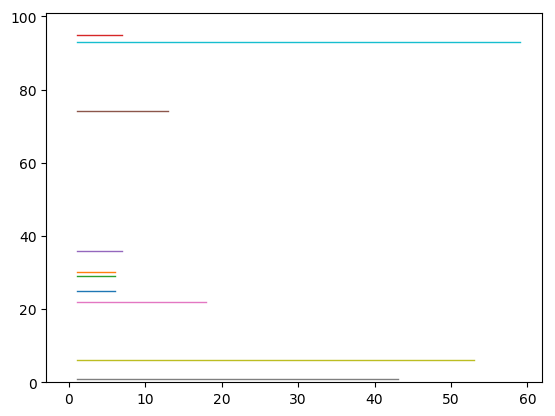

In [12]:
schedulePlot(B_x, B_s, B_z, Duration[1:ntoys]);

This plot reflects our intuition that all toys begin building as soon as possible because we have an excess number of resources.

If we restrict the number of elves to less than the number of toys, we should see an optimal splitting of work:

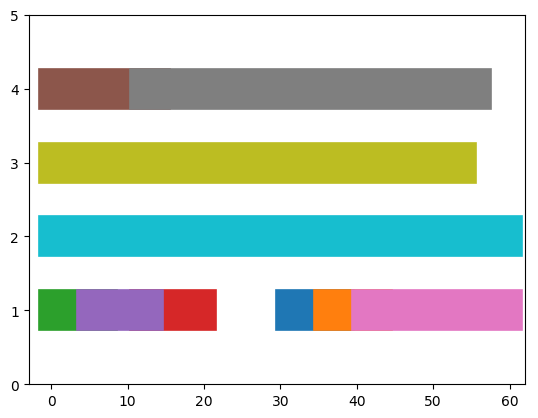

All tasks are completed by: 59.0


In [13]:
num_elves = 4;
ntoys = 10;
Upper = sum(Duration) 
(B_x, B_s, B_z) = minFinishTimeConflict(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper)
println("All tasks are completed by: ", B_z);
schedulePlot(B_x, B_s, B_z, Duration[1:ntoys]);

As we reduce the number of elves further we can see the time to completion increases. We can also observe that an elf may not be working, because the rate-determining step is already being worked on, and there is nothing else that can be done.

All tasks are completed by: 

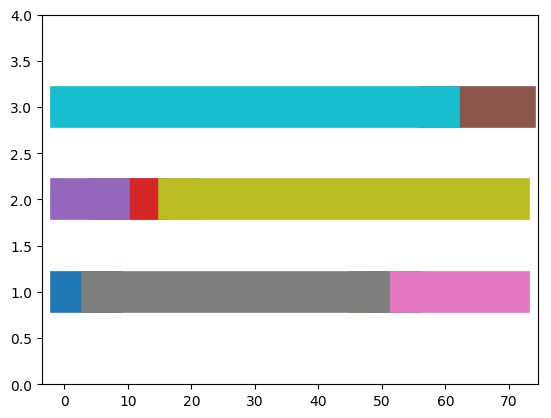

71.0


In [14]:
num_elves = 3;
ntoys = 10;
Upper = sum(Duration) 
(B_x, B_s, B_z) = minFinishTimeConflict(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper)
println("All tasks are completed by: ", B_z);
schedulePlot(B_x, B_s, B_z, Duration[1:ntoys]);

All tasks are completed by: 

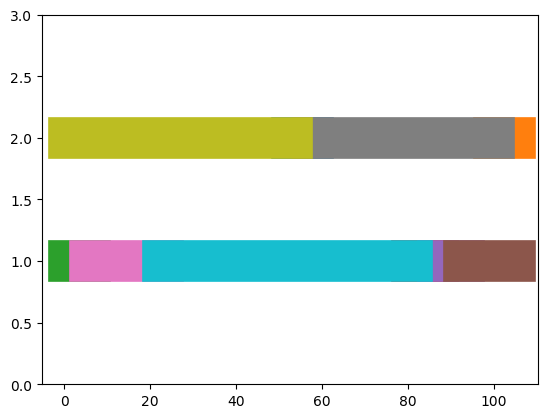

105.0


In [15]:
num_elves = 2;
ntoys = 10;
Upper = sum(Duration) 
(B_x, B_s, B_z) = minFinishTimeConflict(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper)
println("All tasks are completed by: ", B_z);
schedulePlot(B_x, B_s, B_z, Duration[1:ntoys]);

#### Part C

Because we are only running for a small number of toys, to see the effect the workshop times have on the final output we can adjust the workshop close time to be only 1 hour. We also need to adjust our upper bound, as we are now spanning a much larger range of times. The large white gaps in the figures below indicate hours during which work cannot occur, either because the workshop is closed or a toy cannot be started and completed in the time left.

All tasks are completed by day: 

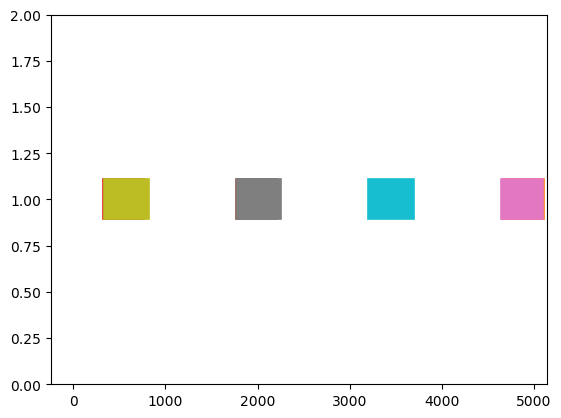

4.0


In [16]:
num_elves = 1;
ntoys = 10;
clos_hr = 10; # opens at 9AM
Upper = sum(Duration)*10 # a toy every hour, every day
(D_x, D_s, D_z, D_d) = minFinishTimeConflictDays(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper, clos_hr);
println("All tasks are completed by day: ", maximum(D_d));
schedulePlot(D_x, D_s, D_z, Duration[1:ntoys]);

All tasks are completed by day: 

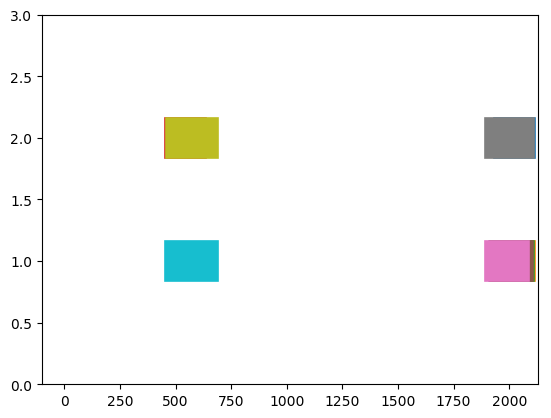

2.0


In [17]:
num_elves = 2;
ntoys = 10;
clos_hr = 10; # opens at 9AM
Upper = sum(Duration)*10 # a toy every hour, every day
(D_x, D_s, D_z, D_d) = minFinishTimeConflictDays(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper, clos_hr);
println("All tasks are completed by day: ", maximum(D_d));
schedulePlot(D_x, D_s, D_z, Duration[1:ntoys]);

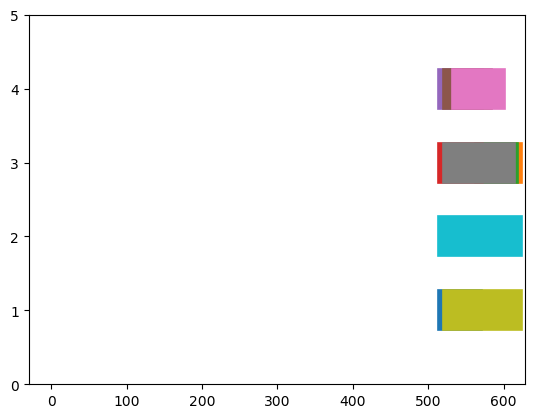

All tasks are completed by day: 1.0


In [18]:
num_elves = 4;
ntoys = 10;
clos_hr = 10; # opens at 9AM
Upper = sum(Duration)*10 # a toy every hour, every day
(D_x, D_s, D_z, D_d) = minFinishTimeConflictDays(Duration[1:ntoys], Arrival_time[1:ntoys], num_elves, Upper, clos_hr);
println("All tasks are completed by day: ", maximum(D_d));
schedulePlot(D_x, D_s, D_z, Duration[1:ntoys]);

### 4.B. Part D: Pareto Tradeoffs ###

We can plot the Pareto Curve as a function of $\lambda$. Below is a version for a maximum of 10 elves working on a total of 10 toys.

In [ ]:
ntoys = 10
max_elves = 10
λ = [10.0^i for i=-4:1:5]
Upper = sum(Duration[1:ntoys])

min_time = zeros(size(λ,1))
usedelf = zeros(size(λ,1))

for i = 1:10
    (min_time[i], usedelf[i]) = Balance(Duration[1:ntoys], Arrival_time[1:ntoys], max_elves, Upper, λ[i]);
end

In [ ]:
using PyPlot
fig = figure(figsize=(7,5))
ylabel("Earliest Completion Time")
xlabel("Number of elves")
title("The optimal solution to balance time and resource")
plot(usedelf, min_time, "ro-")
;

Because we can only run for a small number of toys, the Pareto curve is extremely piecewise. With additional time and computation power, however, we could imagine picking an optimal point on the Paret curve based on many simulations.

### 4.C. Solver Comparisons ###

While testing with different solvers and formulations, we found that Gurobi is significantly faster in finding solutions than Cbc, the only other solver we were able to consistently run. Below is a timing analysis comparing the two over 30 runs of the same problem formulation.

In [ ]:
nNelves = 10;
nRuns = 30;
ntoys = 5;
Upper = sum(Duration[1:ntoys]) 
solvers = ["Gurobi", "Cbc"];
times = zeros(size(solvers,1),nRuns,nNelves);
for e = 1:nNelves
    for t = 1:nRuns
        tic();
        (D_z,D_k) = minFinishTimeConflict(Duration[1:ntoys], Arrival_time[1:ntoys], e, Upper)
        times[1,t,e] = toq();
        tic();
        (D_z,D_k) = minFinishTimeConflictCBC(Duration[1:ntoys], Arrival_time[1:ntoys], e, Upper)
        times[2,t,e] = toq();
    end
end
means = squeeze(mean(times,2),2)';
stds = squeeze(std(times,2),2)';

In [ ]:
errorbar(1:nNelves, means[:,1], yerr = [means[:,1] - stds[:,1], means[:,1] + stds[:,1]]);
hold(true);
errorbar(1:nNelves, means[:,2], yerr = [means[:,2] - stds[:,2], means[:,2] + stds[:,2]]);
legend(solvers, loc = "upper right");
ylabel("Time to Solve (seconds)")
xlabel("Number of elves")
title("Gurobi vs. Cbc")
hold(false);

A significant reason for this large gap seems to be that Gurobi takes significant advantage of multi-core systems. On a research machine with 24 cores, Gurobi is able to take full advantage of multiple cores for its search procedures: usage for all cores jumps to almost 100%. We also observed that this gap acts as expected (reduced) when compared to running on machines with fewer cores (laptops).

### 4.D.-Productivity-Modeling ###

The most difficult part of modeling this problem is the dynamic productivity of each elf. As described in the Introduction, the productivity of an elf increases as they complete toys during workshop times, and decreases as they work during unsanctioned workshop hours (overtime). Even modeling overtime in our formulations is difficult, as we already have an $n^2$ number of variables. Below we attempted to begin modeling these constraints at a high level (pseudocode), but were unable to find a reasonable method of implementing them, especially with the variable and constraint explosion.

```
for i = 1:8760 (total number of hours in 1 year) // Productivity changes only over each hour
	for j = 1:nElves
     		p[i:j] = 1
	end
end;
for j = 1:nElves
	for i = 1:nToys
		if x[j,i] = 1 // mean elf j work on toy i
			// Every time the productivity changes, it means from now till the end of this year, the productivity will change untill a new change.
			for t = finish[i] : 8750
			    if start[i] is sanctioned
			    	P[j,t] = p[j,start[i]](1.2)^(Duration/p[j,start[i]])
				if P[j,t] > 4
					p[j,t] = 4 // we just need to upper constraint its range here
			    else 
				P[j,t] = p[j,start[i]](0.8)^(Duration/p[j,start[i]])
				if P[j,t] < 0.25
					p[j,t] = 0.25 // we just need to lower constraint its range here
			end
		end
	end
end;
```

## 5. More Discussion, Future Work, and Conclusions ##

### Scaling Up

An important part of why we chose this project was the scale of the problem. With a potential 10 million toys and 900 elves, spread across a continuous time period of 1 year, we were excted to try to solve such a large problem. Unfortunately we found that because we needed so many decision variables (Integer variables) and so many constraints, the model size quickly grew to become very infeasible even with 10 to 15 toys.

Addressing this issue may involve trying to relax the prolem to a Linear Program, or switching to another language or platform. 

Additionally, the problem may need to be formulated in a completely different manner. An interesting future direction may be to look at the problem from a different perspective, such as a specific shipment problem, in which we need to allocate a certain amount of elf-hours each day to building toys, we can allocate more hours but they are costly (overtime), and any toys not built must be built the next day. Being agnostic to the number of elves may allow the problem to be easily relaxed to a basic LP, and building upon that may allow for much larger scaling.

### Conclusions

We were able to model a simple version of the problem described in the Kaggle competition. We were able to apply many Integer Programming modeling skills developed in class, and although we were able to see some results, we were not able to scale the problem effectively to the size required for competition. Future work would involve potentially algorithmic improvements, platform changes, or a complete revisit to the model we chose.